<a href="https://colab.research.google.com/github/woncoh1/era1a10/blob/main/S10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Summary
- Data
    - Dataset: CIFAR-10
    - Data augmentation: Albumentations
- Model
    - Model architecture: ResNet
    - Loss function: Cross entropy
- Optimization
    - Optimization algorithm: Adam
    - LR scheduler: One-cycle policy

## Targets
- Test accuracy > 90.0 %
- Number of parameters: unlimited
- Number of epochs: 24

## Results
- Best train accuracy = 97.66 %
- Best test accuracy = 93.02 %
- Number of parameters = 6,573,120
- Number of epochs = 24

In [ ]:
!git clone https://github.com/woncoh1/era1a10.git

fatal: destination path 'era1a10' already exists and is not an empty directory.


In [ ]:
%pip install torchinfo -Uqq
%pip install albumentations -Uqq
%pip install torch-lr-finder -Uqq

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchinfo import summary
from torch_lr_finder import LRFinder

from era1a10.src import data, engine, models, utils

/usr/local/lib/python3.10/dist-packages/torch_lr_finder/lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


# Device

## Colab runtime
- Hardware accelerator: GPU
- GPU type: T4
- Runtime shape: Standard

## Pytorch device
- cpu
- cuda
- mps

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Data

In [ ]:
params_dataloader = {
    'batch_size': 512,
    'shuffle': True,
    'num_workers': 0,
    'pin_memory': True,
}

In [ ]:
transform = data.get_transform()
dataset = data.get_dataset(transform)
loader = data.get_dataloader(dataset, params_dataloader)

Files already downloaded and verified


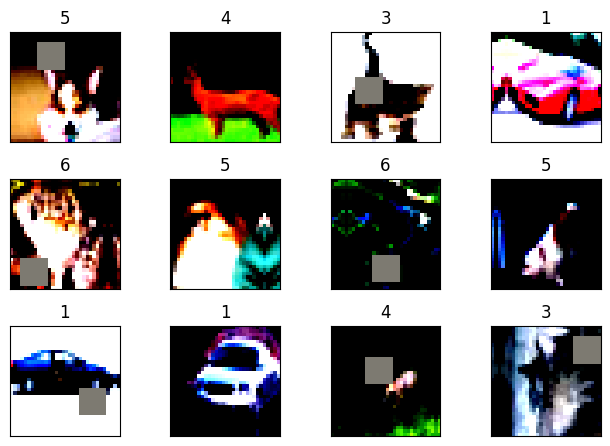

In [ ]:
utils.plot_batch_samples(loader['train'])

# Model

In [ ]:
criterion = nn.CrossEntropyLoss()
model = models.PageNet().to(device)

summary(
    model,
    input_size=(params_dataloader['batch_size'], *data.CHW),
    row_settings=['var_names'],
)

Layer (type (var_name))                  Output Shape              Param #
PageNet (PageNet)                        [512, 10]                 --
├─Sequential (conv0)                     [512, 64, 32, 32]         --
│    └─Conv2d (0)                        [512, 64, 32, 32]         1,728
│    └─BatchNorm2d (1)                   [512, 64, 32, 32]         128
│    └─Dropout (2)                       [512, 64, 32, 32]         --
│    └─ReLU (3)                          [512, 64, 32, 32]         --
├─SkipBlock (conv1)                      [512, 128, 16, 16]        --
│    └─Sequential (conv)                 [512, 128, 16, 16]        --
│    │    └─Conv2d (0)                   [512, 128, 32, 32]        73,728
│    │    └─MaxPool2d (1)                [512, 128, 16, 16]        --
│    │    └─BatchNorm2d (2)              [512, 128, 16, 16]        256
│    │    └─Dropout (3)                  [512, 128, 16, 16]        --
│    │    └─ReLU (4)                     [512, 128, 16, 16]        --
│    └

# Training

## Find max LR

In [ ]:
params_optimizer = {
    'lr': 1E-3,
}
params_lr_finder = {
    'end_lr': 10,
    'num_iter': 200,
    'step_mode': 'exp',
}

In [ ]:
optimizer = optim.Adam(model.parameters(), **params_optimizer)

  0%|          | 0/200 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.74E-03


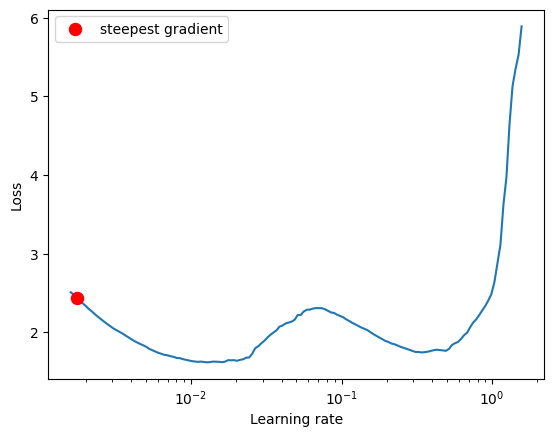

In [ ]:
lr_finder = LRFinder(model, optimizer, criterion, device='cuda')
lr_finder.range_test(loader['train'], **params_lr_finder)
lr_finder.plot() # Inspect the loss-learning rate graph
lr_finder.reset() # Reset the model and optimizer to their initial states

## Update weights

In [ ]:
params_trainer = {
    'num_epochs': 24,
}
params_scheduler = {
    'max_lr': 2E-3, # From lr_finder
    'epochs': params_trainer['num_epochs'],
    'steps_per_epoch': len(loader['train']), # 1 batch per step
    'pct_start': 0.2, # 20 % warm-up phase
    'anneal_strategy': 'linear', # Linear cool-down phase
    'three_phase': False, # No annihilation phase
    'div_factor': 100, # Initial LR: start from 1 % of max_lr
}

scheduler = optim.lr_scheduler.OneCycleLR(optimizer, **params_scheduler)

results = engine.train(
    device,
    loader['train'],
    loader['test'],
    model,
    criterion,
    optimizer,
    scheduler,
    params_trainer['num_epochs'],
)

  0%|          | 0/98 [00:00<?, ?it/s]

Train: Loss = 0.00309, Accuracy = 43.21%, Epoch = 1
Test : Loss = 0.00262, Accuracy = 52.78%



  0%|          | 0/98 [00:00<?, ?it/s]

Train: Loss = 0.00206, Accuracy = 62.69%, Epoch = 2
Test : Loss = 0.00173, Accuracy = 69.07%



  0%|          | 0/98 [00:00<?, ?it/s]

Train: Loss = 0.00155, Accuracy = 72.07%, Epoch = 3
Test : Loss = 0.00140, Accuracy = 75.29%



  0%|          | 0/98 [00:00<?, ?it/s]

Train: Loss = 0.00129, Accuracy = 76.95%, Epoch = 4
Test : Loss = 0.00118, Accuracy = 79.30%



  0%|          | 0/98 [00:00<?, ?it/s]

Train: Loss = 0.00113, Accuracy = 79.85%, Epoch = 5
Test : Loss = 0.00122, Accuracy = 79.10%



  0%|          | 0/98 [00:00<?, ?it/s]

Train: Loss = 0.00098, Accuracy = 82.46%, Epoch = 6
Test : Loss = 0.00091, Accuracy = 84.37%



  0%|          | 0/98 [00:00<?, ?it/s]

Train: Loss = 0.00088, Accuracy = 84.26%, Epoch = 7
Test : Loss = 0.00103, Accuracy = 83.29%



  0%|          | 0/98 [00:00<?, ?it/s]

Train: Loss = 0.00076, Accuracy = 86.39%, Epoch = 8
Test : Loss = 0.00090, Accuracy = 84.86%



  0%|          | 0/98 [00:00<?, ?it/s]

Train: Loss = 0.00068, Accuracy = 87.99%, Epoch = 9
Test : Loss = 0.00083, Accuracy = 86.01%



  0%|          | 0/98 [00:00<?, ?it/s]

Train: Loss = 0.00061, Accuracy = 89.35%, Epoch = 10
Test : Loss = 0.00088, Accuracy = 85.35%



  0%|          | 0/98 [00:00<?, ?it/s]

Train: Loss = 0.00057, Accuracy = 89.85%, Epoch = 11
Test : Loss = 0.00073, Accuracy = 87.25%



  0%|          | 0/98 [00:00<?, ?it/s]

Train: Loss = 0.00050, Accuracy = 90.96%, Epoch = 12
Test : Loss = 0.00066, Accuracy = 89.01%



  0%|          | 0/98 [00:00<?, ?it/s]

Train: Loss = 0.00047, Accuracy = 91.77%, Epoch = 13
Test : Loss = 0.00065, Accuracy = 89.04%



  0%|          | 0/98 [00:00<?, ?it/s]

Train: Loss = 0.00043, Accuracy = 92.43%, Epoch = 14
Test : Loss = 0.00064, Accuracy = 89.37%



  0%|          | 0/98 [00:00<?, ?it/s]

Train: Loss = 0.00038, Accuracy = 93.12%, Epoch = 15
Test : Loss = 0.00058, Accuracy = 90.59%



  0%|          | 0/98 [00:00<?, ?it/s]

Train: Loss = 0.00034, Accuracy = 93.81%, Epoch = 16
Test : Loss = 0.00061, Accuracy = 90.29%



  0%|          | 0/98 [00:00<?, ?it/s]

Train: Loss = 0.00031, Accuracy = 94.57%, Epoch = 17
Test : Loss = 0.00056, Accuracy = 90.76%



  0%|          | 0/98 [00:00<?, ?it/s]

Train: Loss = 0.00028, Accuracy = 95.07%, Epoch = 18
Test : Loss = 0.00053, Accuracy = 91.50%



  0%|          | 0/98 [00:00<?, ?it/s]

Train: Loss = 0.00024, Accuracy = 95.75%, Epoch = 19
Test : Loss = 0.00054, Accuracy = 91.37%



  0%|          | 0/98 [00:00<?, ?it/s]

Train: Loss = 0.00022, Accuracy = 96.17%, Epoch = 20
Test : Loss = 0.00050, Accuracy = 91.73%



  0%|          | 0/98 [00:00<?, ?it/s]

Train: Loss = 0.00020, Accuracy = 96.60%, Epoch = 21
Test : Loss = 0.00049, Accuracy = 92.11%



  0%|          | 0/98 [00:00<?, ?it/s]

Train: Loss = 0.00017, Accuracy = 97.13%, Epoch = 22
Test : Loss = 0.00048, Accuracy = 92.70%



  0%|          | 0/98 [00:00<?, ?it/s]

Train: Loss = 0.00016, Accuracy = 97.44%, Epoch = 23
Test : Loss = 0.00046, Accuracy = 92.65%



  0%|          | 0/98 [00:00<?, ?it/s]

Train: Loss = 0.00014, Accuracy = 97.66%, Epoch = 24
Test : Loss = 0.00045, Accuracy = 93.02%



# Evaluation

## Learning curves

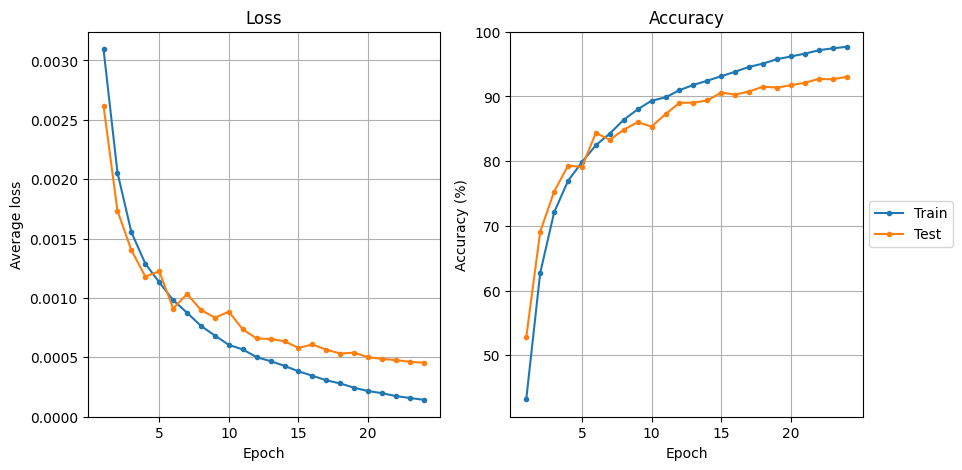

In [ ]:
utils.plot_learning_curves(results, params_trainer['num_epochs'])

## Incorrect predictions

In [ ]:
incorrects = utils.get_incorrect_predictions(
    device,
    data.get_dataloader(dataset, params_dataloader)['test'],
    model,
    criterion
)

Total Incorrect Predictions 698


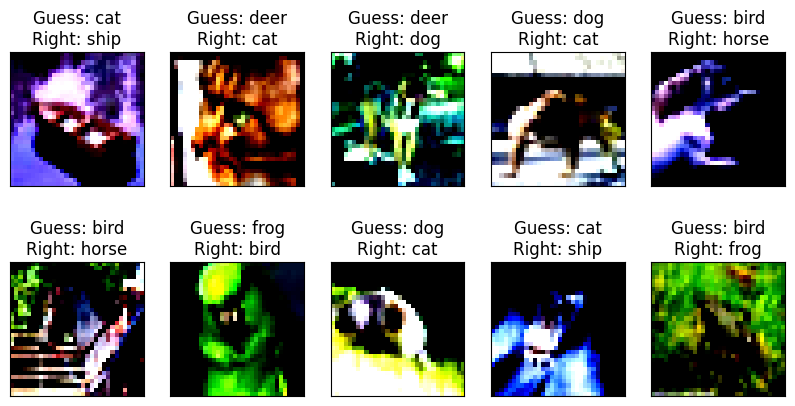

In [ ]:
utils.plot_incorrect_predictions(incorrects, data.CLASSES)